In [1]:
import numpy as np
from sympy import init_session,Matrix
import tensorflow as tf
from skimage import data as sc_data
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow import keras
plt.rcParams['image.cmap']='gray'
#%matplotlib inline
tf.random.set_seed(100)
plt.ion()

# Convolutional Neural Networks
Convolutional Neural Networks (CNNs) are designed in such a way, that they preserve the spatial structure of the input and have shown excellent performance on several applications including image classification, object detection, semantic segmentation, natural language processing and medical image analysis. CNNs employs a mathematical operation called ``convolution``

# Convolution Operation
In its most general form convolution is a mathematical operator which takes two functions f and g and produces a third function s. It is the overlap of f and g as g is shifted over f and is defined as
$$ s(t)=(f*g)(n)=\int_{-\infty}^{\infty}f(m)g(n-m)dm $$

Convolutions are often used for filtering.
```The convolution operation is denoted with an asterisk```

In CNNs terminology, the first argument f to the convolution is often referred to as the input and the second argument g as the convolution kernel or a filter
kernel. The output is sometimes referred to as the feature map.

Convolution is commutative  so it can be written as

$$ s(t)=(f*g)(n)=\int_{-\infty}^{\infty}f(n-m)g(m)dm $$
# Discrete Convolution
If we assume that f and g are defined only on integer n then we can define the discrete convolution as
$$ s(t)=(f*g)(n)=\sum_{m=-\infty}^{\infty}f(m)g(n-m) $$


# 2-Dimensional Convolution

Let $I$ be our $2D$ image (input) and  and $K$ a kernel of size $m \times n$ . The image $I$ is convolved with the filter $K$ and produces the <b>feature map S</b>.
The convolution operation denoted by $I*K$ is given as
$$ S(i,j)=(I * K)(i,j)=\sum_{m}\sum_{n}I(m,n)K(i-m,j-n)=\sum_{m}\sum_{n}I(i-m,j-n) K(m,n) $$ 

where $I(i,j)$  denote the pixel at location (i, j) in the input image

``` NOTE: what most machine learning libraries implement are more accurately described as cross-correlations but instead they call it Convolution```


# The Cross-Correlation Operation
The cross-correlation operation for I and K is defined as

$$ S(i,j)=(I * K)(i,j)=\sum_{m}\sum_{n}I(m,n)K(i+m,j+n)=\sum_{m}\sum_{n}I(i+m,j+n) K(m,n) $$ 


# Convolutional Layer


A convolutional layer consist of a set of learnable kernels (filters). During the forward pass, we cross-correlate (slide) 

over all the spataial loctaions of the input `I` and compute the dot products between the entries of the kernel and the input at any position. As we slide the filter or kernel over the width and height of the input we will produce a 2-dimensional feature map that gives the response of that filter at every spatial position. An input `I` of size $I_{h} × I_{w}$ and a kernel `K` of size $K_{h} × K_{w}$ will give an  `Output` of size
$output=(I_{}-K_{h}+1) \times (I_{w}-K_{w}+1) $

# Locality and Translation Invariance
Locality: Nearby pixels are strongly correlated

Translation Inavariance: Object in the image can occur or appear anywhere in the image 

 A function to compute the Cross-correlation operation between `input X`and `kernel K`

In [2]:
def Corr2D(X,K):
    h,w=K.shape[0],K.shape[1]
    Y=np.zeros([X.shape[0]-h+1,X.shape[1]-w+1])
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j]=np.array(X[i:i+h,j:j+w]*K).sum()
    return Y

![Two-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times0+1\times1+3\times2+4\times3=19$.](../images/correlation.svg)

source[CNNs](http://d2l.ai/chapter_convolutional-neural-networks/conv-layer.htm


# NB:

The receptive field is the size of the region in the input (patch) that produces the output  value.
The receptive field of the output  value 19 is the four elements in the shaded portion of the input image.

In [3]:
X = np.array([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = np.array([[0.0, 1.0], [2.0, 3.0]])
print(X.shape)
Matrix(X)

(3, 3)


Matrix([
[  0, 1.0, 2.0],
[3.0, 4.0, 5.0],
[6.0, 7.0, 8.0]])

In [4]:
Matrix(K)

Matrix([
[  0, 1.0],
[2.0, 3.0]])

In [5]:
Corr2D(X, K)

array([[19., 25.],
       [37., 43.]])

In [6]:
K = np.array([[0.0, 1.0], [2.0, 3.0]])
K_initials=tf.keras.initializers.Constant(K)

In [7]:
def comp_conv2d(conv2d, X):
    # Here (1, 1) indicates that the batch size and the number of channels
    # are both 1
    X=tf.reshape(X,(1,)+X.shape+(1,))
    Y=conv2d(X)
    # Exclude the first two dimensions that do not interest us: examples and
    # channel
    return tf.reshape(Y,Y.shape[1:3])

In [8]:
con2d=tf.keras.layers.Conv2D(1,kernel_size=(2,2),kernel_initializer=K_initials)

result=comp_conv2d(con2d,X)
Matrix(result)

Matrix([
[19.0, 25.0],
[37.0, 43.0]])

In [9]:
X = np.array([[0.0, 1.0, 2.0,3,0,3], [4,3.0, 4.0, 5.0,0.0,5], [5,0,6.0, 7.0,2, 8.0],[7,1,4.0,2,5,6],[3,1,1,2,4,5],
             [1,2,3,4,5,6]])
con2d=tf.keras.layers.Conv2D(1,kernel_size=(2,2),kernel_initializer=K_initials)
corr_I_k=comp_conv2d(con2d,X)
corr_I_k

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[18., 20., 26., 10., 18.],
       [13., 22., 38., 20., 33.],
       [17., 20., 21., 21., 36.],
       [10.,  9., 10., 21., 29.],
       [ 9., 14., 20., 27., 33.]], dtype=float32)>

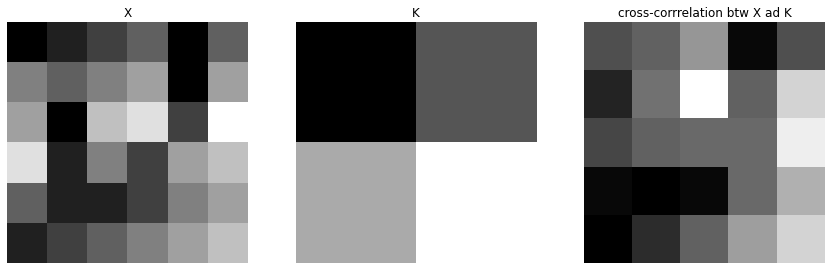

In [10]:
plt.figure(figsize=(25,10))
plt.subplot(151),plt.imshow(X),plt.title('X'),plt.axis('off')
plt.subplot(152),plt.imshow(K_initials.value),plt.title('K'),plt.axis('off')
plt.subplot(153),plt.imshow(corr_I_k),plt.title('cross-corrrelation btw X ad K'),plt.axis('off')

plt.show()

# STRIDES
Stride is the number of rows and columns traversed per slide when computing the cross-correlation between the input tensor I and kernel K. Sliding is defaulted to one element at a time. However, sometimes, either for the reduction of computational cost or because we wish to downsample we skip the intermediate locations by moving the window more than one element at a time. The number of the imtermediate locations we skip is determining by the stride number set.

An input `I` of size $I_{h} × I_{w}$ and a kernel `K` of size $K_{h} × K_{w}$ sliding with a size $S_{h} × S_{w}$  
will give an  `Output` of size
$output=\frac{I_{}-K_{h}+S_{h}}{S_{h}} \times \frac{I_{w}-K_{w}+S_{w}}{S_{w}} $

 If we represent the size of output by $m \times n$ where $m =\frac{I_{}-K_{h}+S_{h}}{S_{h}}$ and $n= \frac{I_{w}-K_{w}+S_{w}}{S_{w}} $

The output size is given by the  $floor(m) \times floor(n)   $

The output size is given by the  $\lfloor{m}\rfloor \times \lfloor{n}\rfloor $

In [11]:
X = np.array([[0.0, 1.0, 2.0,3,0], [4,3.0, 4.0, 5.0,0.0], [6.0, 7.0,2, 8.0,9],[7,4.0,2,5,6],[1,1,2,4,5],
             [1,2,3,4,5]])
print(X.shape)

(6, 5)


In [12]:
con2d=tf.keras.layers.Conv2D(1,kernel_size=(2,2),strides=(2,2),kernel_initializer=K_initials )
comp_conv2d(con2d,X).shape

TensorShape([3, 2])

In [13]:
X = np.array([[0.0, 1.0, 2.0,3,0], [4,3.0, 4.0, 5.0,0.0], [6.0, 7.0,2,3, 8.0],[7,4.0,2,5,6],[1,1,2,4,5]])
X.shape
con2d=tf.keras.layers.Conv2D(1,kernel_size=(2,2),strides=(2,2),kernel_initializer=K_initials )
comp_conv2d(con2d,X).shape

TensorShape([2, 2])

# PADDING
After applying a convolutional layer to our imput, it reduces the size of the output feature map. Since we typically use small kernels, for any given convolution, we might only lose a few pixels, but this can add up as we apply many successive convolutional layers. One solution to this problem is to add extra pixels of filler of which the values are usually set to zero around the boundary of our input image `(known as Padding)`, thus increasing the effective size of the image. 

An input `I` of size $I_{h} × I_{w}$ and a kernel `K` of size $K_{h} × K_{w}$ sliding with a size $S_{h} × S_{w}$  
and padding with size $P_{h} \times P_{w}$
will give an   `Output (feature map)` of size
$output=\frac{I_{h}+2*P_{h}-K_{h}+S_{h}}{S_{h}} \times \frac{I_{w}+2*P_{w}-K_{w}+S_{w}}{S_{w}} $

 If we represent the size of output by $m \times n$ where $m =\frac{I_{h} +2*P_{w}-K_{h}+S_{h}}{S_{h}}$ and $n= \frac{I_{w}+2*P_{w}-K_{w}+S_{w}}{S_{w}} $

The output size is given by the  $floor(m) \times floor(n)   $

The output size is given by the  $\lfloor{m}\rfloor \times \lfloor{n}\rfloor $

# NOTE 
in keras to calculate the expected output shape when padding is set to `same` and $S\neq 1$ then the value of $P=1$ but with $S=1$ then $P=\frac{K-1}{2}$

In [14]:
X = np.array([[0.0, 1.0, 2.0,3,0], [4,3.0, 4.0, 5.0,0.0], [6.0, 7.0,2,3, 8.0],[7,4.0,2,5,6],[1,1,2,4,5]])
con2d=tf.keras.layers.Conv2D(1,kernel_size=(2,2),strides=(2,2),kernel_initializer=K_initials,padding='same' )
comp_conv2d(con2d,X).shape

TensorShape([3, 3])

In [15]:
X = np.array([[0.0, 1.0, 2.0,3,0], [4,3.0, 4.0, 5.0,0.0], [6.0, 7.0,2,3, 8.0],[7,4.0,2,5,6],[1,1,2,4,5]])
con2d=tf.keras.layers.Conv2D(1,kernel_size=(2,2),strides=(4,3),kernel_initializer=K_initials,padding='same' )
comp_conv2d(con2d,X).shape

TensorShape([2, 2])

In [16]:
X = np.array([[0.0, 1.0, 2.0,3,0], [4,3.0, 4.0, 5.0,0.0], [6.0, 7.0,2,3, 8.0],[7,4.0,2,5,6],[1,1,2,4,5]])
print(X.shape)
con2d=tf.keras.layers.Conv2D(1,kernel_size=(2,2),kernel_initializer=K_initials,padding='same' )
comp_conv2d(con2d,X).shape

(5, 5)


TensorShape([5, 5])

# POOLING LAYER

A pooling function replaces the output of the net at a certain location with a summary statistic of the nearby outputs. The pooling layer contains no parameters (there is no kernel). Instead, pooling operators typically calculate either the maximum or the average value of the elements in the pooling window. These operations are called maximum pooling (max pooling for short) and average pooling, respectively

# Max pooling, 
Max pooling splits the input into (usually non-overlapping) patches and output the maximum value of each patch

`` NB: in keras  strides values which specifies how far the pooling window moves for each pooling step is default to the`pool_size``.

After applying the `MAX POOLING` layer the resulting output shape will be

`output_shape = math.floor((input_shape - pool_size) / strides) + 1` when using the `"valid"` (the defualt) padding option

and 


`output_shape = math.floor((input_shape - 1) / strides) + 1`  when using the `"same"` padding option.


# APPLYING THESE TECHNIQUES ON A REAL IMAGE

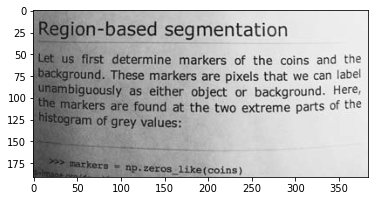

In [17]:
text=sc_data.page()
text=text.astype('float64')
plt.imshow(text)

# Effect of kernel when used in convolution operations

In [18]:
con2d=tf.keras.layers.Conv2D(1,kernel_size=(2,2) )
cor_stride1=comp_conv2d(con2d,text)

con2d=tf.keras.layers.Conv2D(1,kernel_size=2,padding='same')
padded=comp_conv2d(con2d,text)

con2d=tf.keras.layers.Conv2D(1,kernel_size=(2,2),strides=(2,2))
cor_stride2=comp_conv2d(con2d,text)

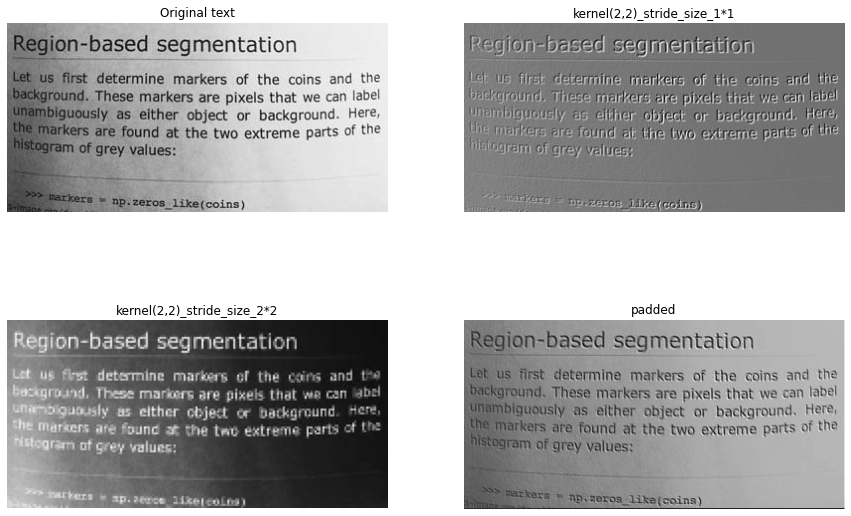

In [19]:

imgs=[text,cor_stride1,cor_stride2,padded ]
t=['Original text','kernel(2,2)_stride_size_1*1','kernel(2,2)_stride_size_2*2','padded' ]

f,axes=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
axes=axes.ravel()
for ax in axes:
    ax.axis('off')
    
for i,c in enumerate(imgs):
    axes[i].imshow(c)
    axes[i].set_title(t[i])



# Multiple  Channels

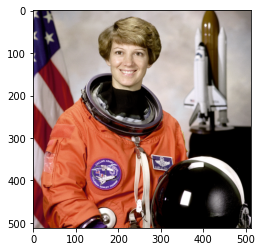

In [20]:
astronaut=sc_data.astronaut()
plt.imshow(astronaut)

In [21]:
astronaut.shape

(512, 512, 3)

$ h\times w \times 3$. We refer to the axis with a size of 3 as the channel dimension

In [22]:
def Comp_Mutlti(conv2d, image):
    img=tf.expand_dims(image,0)
    img=tf.dtypes.cast(img,tf.float32)
    Y=conv2d(img)
    # Exclude the first dimension that do not interest us: examples 
    return tf.reshape(Y,Y.shape[1:4])

The filter argument in the 2D convolution layer specifies the number of feature maps to be generated with 2D convolution layer.

In [23]:
con2d=tf.keras.layers.Conv2D(filters=3,kernel_size=(2,2),kernel_initializer='ones' )
a=Comp_Mutlti(con2d,astronaut)
#plt.imshow(a)
a.shape

TensorShape([511, 511, 3])

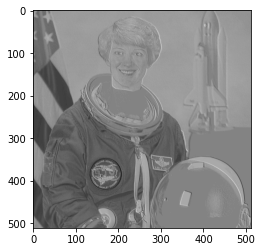

In [24]:
con2d=tf.keras.layers.Conv2D(filters=1,kernel_size=(2,2))
a=Comp_Mutlti(con2d,astronaut)
plt.imshow(a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


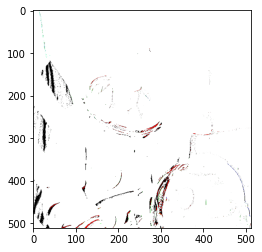

In [25]:
con2d=tf.keras.layers.Conv2D(filters=4,kernel_size=(2,2))
con_imgs=Comp_Mutlti(con2d,astronaut)
plt.imshow(con_imgs)

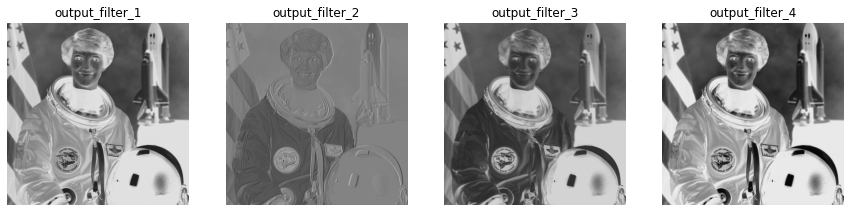

In [26]:
plt.figure( figsize=(15,10))
t=['output_filter_1','output_filter_2','output_filter_3', 'output_filter_4']  
for i in range(4):
    axes=plt.subplot(1,4,i+1)
    axes.imshow(con_imgs[:,:,i])
    axes.set_title(t[i])
    axes.axis('off')


# Let  now apply the Pooling Layer and plot the feature maps

In [27]:
def Pool_layer(pool_layer, image):
    img=tf.expand_dims(image,0)
    img=tf.dtypes.cast(img,tf.float32)
    Y=pool_layer(img)
    # Exclude the first dimension that do not interest us: examples 
    return tf.reshape(Y,Y.shape[1:4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(255, 255, 4)


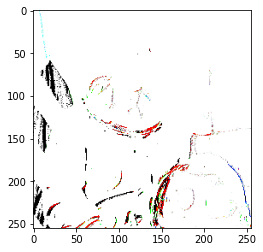

In [28]:
max_pool=tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2)
after_max_pool=Pool_layer(max_pool,con_imgs)
print(after_max_pool.shape)
plt.imshow(after_max_pool)

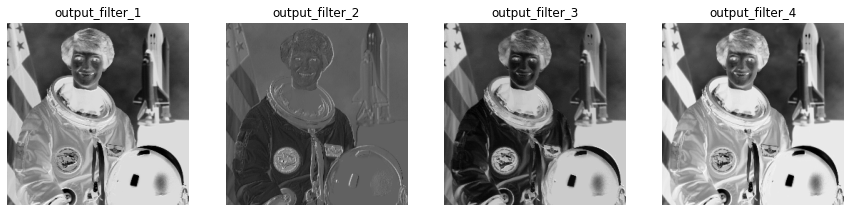

In [29]:
plt.figure( figsize=(15,10))
t=['output_filter_1','output_filter_2','output_filter_3', 'output_filter_4']  
for i in range(4):
    axes=plt.subplot(1,4,i+1)
    axes.imshow(after_max_pool[:,:,i])
    axes.set_title(t[i])
    axes.axis('off')
plt.show()

In [30]:
print("output shape of convolution layer",con_imgs.shape)
print('output shape of maxpooling layers', after_max_pool.shape)

output shape of convolution layer (511, 511, 4)
output shape of maxpooling layers (255, 255, 4)
